### Setup Colab

In [ ]:
# %load_ext autoreload
# %autoreload 2
# #colab config
# from google.colab import drive

# drive.mount('/content/drive')

# import os

# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'NYU ML'

# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# os.chdir(GOOGLE_DRIVE_PATH)

# print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/My Drive/NYU ML


In [ ]:
# !pip install gcsfs==2024.9.0.post1 fsspec==2024.9.0
# !pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: gcsfs
    Found existing installation: gcsfs 2024.10.0
    Uninstalling gcsfs-2024.10.0:
      Successfully uninstalled gcsfs-2024.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.8 MB/s eta 0:00:00


# Import

In [204]:
from datasets import load_dataset
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import pandas as pd
import re
import joblib


### Load Data

In [2]:
# total_dataset = load_dataset("MissTiny/WikiArt",cache_dir="data")
total_dataset = load_dataset("MissTiny/WikiArts_contrained",cache_dir="WikiArts_contrained")

Resolving data files:   0%|          | 0/55 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/55 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/50 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

In [3]:
total_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'image_numpy', 'CLIPVisionModelWithProjection_image_embeds'],
        num_rows: 48091
    })
    test: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'image_numpy', 'CLIPVisionModelWithProjection_image_embeds'],
        num_rows: 16042
    })
})

In [4]:
X_train = np.array(total_dataset['train']['CLIPVisionModelWithProjection_image_embeds'])
y_train = total_dataset['train']['date']
y_train = np.array([int(year) for year in y_train], dtype = int) # year int

X_test = np.array(total_dataset['test']['CLIPVisionModelWithProjection_image_embeds'])
y_test = total_dataset['test']['date']
y_test = np.array([int(year) for year in y_test], dtype = int)

filter_mask = (y_train > 1800) & (y_train <2000)
X_train = X_train[filter_mask]
y_train = y_train[filter_mask]

filter_mask = (y_test > 1800) & (y_test <2000)
X_test = X_test[filter_mask]
y_test = y_test[filter_mask]



In [5]:
# # normalize (not required)
# norms = np.linalg.norm(X_train, axis=1, keepdims=True)  # Compute the L2 norm for each embedding
# X_train = X_train / norms
# norms = np.linalg.norm(X_test, axis=1, keepdims=True)  # Compute the L2 norm for each embedding
# X_test = X_test / norms

In [8]:
min_year = min(min(y_train), min(y_test))
max_year = max(max(y_train), max(y_test))
range_year = max_year - min_year
interval_year = 20
num_c = math.ceil(range_year / interval_year)
year_book = np.linspace(min_year, min_year+num_c*interval_year, num_c+1, dtype = int)
print(min_year, max_year, range_year, interval_year, num_c, year_book)

1801 1999 198 20 10 [1801 1821 1841 1861 1881 1901 1921 1941 1961 1981 2001]


In [9]:
# filter_mask = (y_train > 1800) & (y_train <2000)
# X_train_filter = X_train[filter_mask]
# y_train_filter = y_train[filter_mask]

In [10]:
mini_data_size = X_train.shape[0]
X_mini = X_train[:mini_data_size]
y_mini = y_train[:mini_data_size]


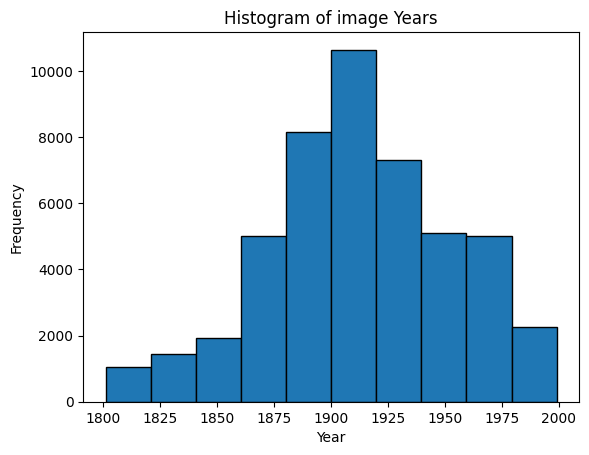

In [11]:
plt.hist(y_train, bins=num_c, edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of image Years')

# Display the histogram
plt.show()

In [342]:
# year string to 1 hot code
def date_to_1hot(y, interval_year = interval_year, range_year = range_year, min_year=min_year, max_year=max_year):
    num_item = y.shape[0]
    num_features = math.ceil(range_year / interval_year)
    
    y_label = np.zeros((num_item, num_features))
    for i in range(num_item):
        index = (y[i] - min_year) // interval_year
        y_label[i][index] = 1
    
    return y_label

# year int to class
def date_to_class(y, interval_year = interval_year, range_year = range_year, min_year=min_year, max_year=max_year, year_book = year_book):
    y_class = np.zeros_like(y)
    for i in range(y_class.shape[0]):
        y_class[i] = (y[i] - min_year)//interval_year
    return y_class

def date_nearby(y, interval_year = interval_year, range_year = range_year, min_year=min_year, max_year=max_year, year_book = year_book):
    y_class = np.zeros_like(y)
    for i in range(y_class.shape[0]):
        year_floor = (y[i] - min_year)//interval_year*interval_year + min_year
        gap = y[i] - year_floor
        if gap <interval_year/2:
            y_class[i] = year_floor
        else:    
            y_class[i] = year_floor + interval_year
    return y_class


def accuracy_conferral(y_test, y_pred, interval = interval_year):
    count = 0
    total = y_test.shape[0]
    for i in range(total):
        diff = abs(y_test[i]-y_pred[i])
        if diff <= interval:
            count +=1
    return count/total



## generally data analysis

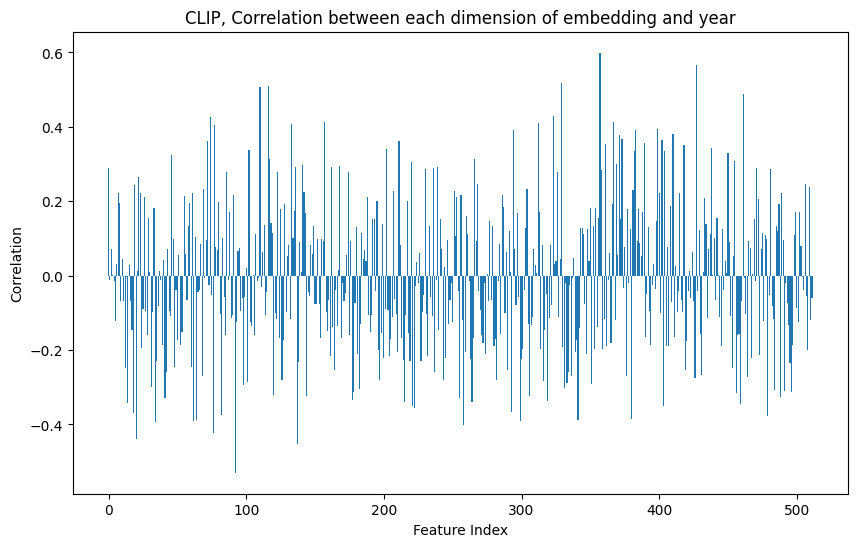

In [302]:
y_train_f = date_floor(y_train)
num_feature = X_train.shape[1]
correlation_record = np.zeros(num_feature)
for i in range(num_feature):
    correlation_matrix = np.corrcoef(y_train_f, X_train[:,i])
    correlation_record[i] = correlation_matrix[0,1]
    # correlation_record[i] = np.mean(X_train[:,i])


# Plotting
plt.figure(figsize=(10, 6))

plt.bar(range(num_feature), correlation_record)
plt.xlabel('Feature Index')
plt.ylabel('Correlation')
plt.title('CLIP, Correlation between each dimension of embedding and year')
plt.show()


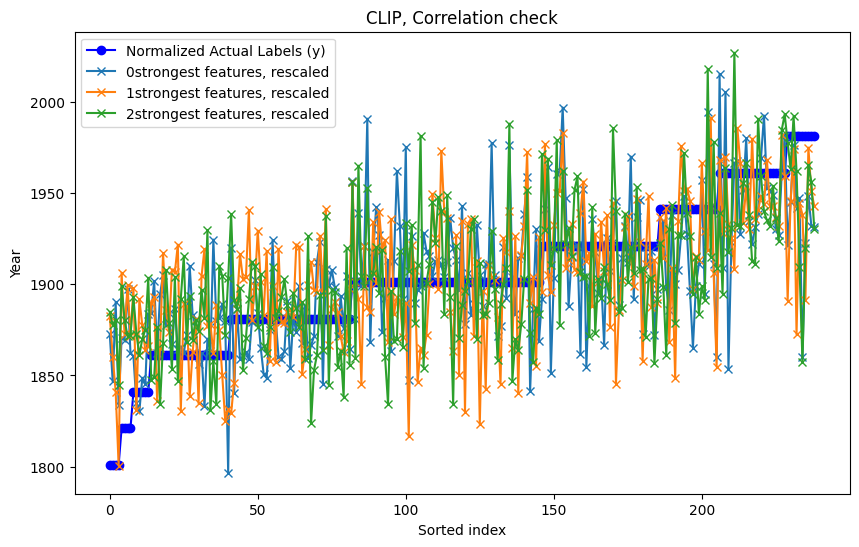

In [304]:
corre_index = np.argsort(correlation_record)[::-1]
y_train_f = date_floor(y_train)


sample_size = int(len(y_train_f) * 0.005)  # Adjust the percentage as needed
indices = np.random.choice(len(y_train_f), sample_size, replace=False)



y_train_show = y_train_f
y_train_show = y_train_show[indices]
year_sorted = np.argsort(y_train_show)
y_train_show = y_train_show[year_sorted]
show_mean = np.mean(y_train_show)
show_std = np.std(y_train_show)

num_pre = 3
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(y_train_show, label='Normalized Actual Labels (y)', marker='o', linestyle='-', color='b')
for i in range(num_pre):
    feature_to_show = X_train[indices][:,corre_index[i]][year_sorted]
    feature_mean = np.mean(feature_to_show)
    feature_std = np.std(feature_to_show)
    feature_to_show = (feature_to_show-feature_mean)/feature_std*show_std+show_mean
    plt.plot(feature_to_show, label=str(i)+"strongest features, rescaled" , marker='x',linestyle='-')

plt.xlabel('Sorted index')
plt.ylabel('Year')
plt.title('CLIP, Correlation check')
plt.legend()

plt.show()




## Random forest classifier


Overfit Mini dataset

In [9]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

In [10]:
# y_mini_label = date_to_1hot(y_mini)

In [117]:
# # Assuming X_train, y_train are your training data and X_test, y_test are your test data
# # RandomForest classifier
# classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the model
# classifier.fit(X_mini, y_mini_label)

# # Make predictions
# y_mini_pred_rf = classifier.predict(X_mini)

In [118]:
# # Evaluate accuracy
# accuracy = accuracy_score(y_mini_label, y_mini_pred_rf)
# print(f'Accuracy: {accuracy}')

Accuracy: 0.9986


The whole dataset

In [119]:
# y_train_label = date_to_1hot(y_train)
# y_test_label = date_to_1hot(y_test)

In [ ]:
# # Assuming X_train, y_train are your training data and X_test, y_test are your test data
# # RandomForest classifier
# classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the model
# classifier.fit(X_train, y_train_label)

# # Make predictions
# y_pred_rf = classifier.predict(X_test)

In [ ]:
# accuracy_rf = accuracy_score(y_test_label, y_pred_rf)
# print(f'Accuracy: {accuracy_rf}')

# XGBoost

In [93]:
y_mini_f = date_floor(y_mini)
print(y_mini_f)

[1901 1901 1921 ... 1901 1921 1821]


In [94]:
le = LabelEncoder()
le.fit(y_mini_f)
y_mini_le = le.transform(y_mini_f)

In [95]:
# Define the XGBoost model for multi-class classification
model0 = xgb.XGBClassifier(
    objective='multi:softmax',  # Specify multi-class classification
    num_class=num_c,               # Set the number of classes
    eval_metric='mlogloss'      # Log loss metric for multi-class
)



# Train the model
model0.fit(X_mini, y_mini_le)

# Make predictions
y_mini_xg = model0.predict(X_mini)

y_mini_f_xg =le.inverse_transform(y_mini_xg) 

# Evaluate the model
accuracy = accuracy_score(y_mini_f_xg, y_mini_f)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9734601902854282


### Whole dataset

In [96]:
y_train_f = date_floor(y_train)
y_test_f = date_floor(y_test)

le = LabelEncoder()
le.fit(y_train_f)
y_train_le = le.transform(y_train_f)


In [97]:
# Define the XGBoost model for multi-class classification
model1 = xgb.XGBClassifier(
    objective='multi:softmax',  # Specify multi-class classification
    num_class=len(le.classes_),               # Set the number of classes
    eval_metric='mlogloss'      # Log loss metric for multi-class
)



# Train the model
model1.fit(X_train, y_train_le)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=10, num_parallel_tree=None, ...)

In [98]:
# Make predictions
# y_test_xg = model.predict(y_test)
y_test_xg = model1.predict(X_test)

# y_test_f_xg = le.inverse_transform(y_test_xg)
y_test_f_xg = le.inverse_transform(y_test_xg)

# Evaluate the model
accuracy = accuracy_score(y_test_f_xg, y_test_f)
print(f'Accuracy: {accuracy}')


Accuracy: 0.4726545409088068


In [99]:
y_pred_prob = model1.predict_proba(X_test)

unique_y_train = np.unique(y_train_f)
unique_y_test = np.unique(y_test_f)
classes_in_test_not_in_train = np.setdiff1d(unique_y_test, unique_y_train)
if classes_in_test_not_in_train.shape[0] != 0:
    print("There is at least 1 class in y_test that does not exist in y_train. We need to redesign codes to consider this issue.")
y_test_le = le.transform(y_test_f)


auc = roc_auc_score(y_test_le, y_pred_prob, multi_class='ovr', average='weighted')
print(f'AUC: {auc}')

AUC: 0.8642000767677577


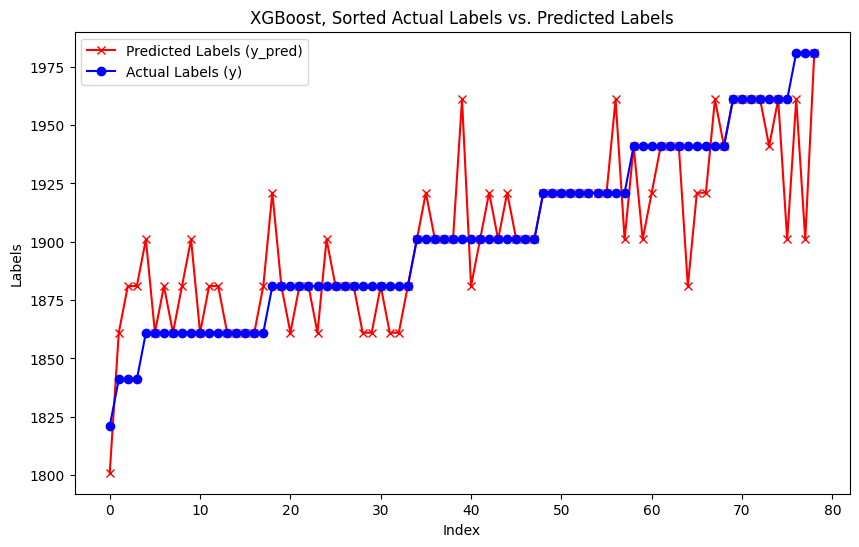

In [193]:
sample_size = int(len(y_test_f) * 0.005)  # Adjust the percentage as needed
indices = np.random.choice(len(y_test_f), sample_size, replace=False)

sorted_indices = np.argsort(y_test_f[indices])

# Rearrange y_pred according to the sorted y
y_test_f_sorted = y_test_f[indices][sorted_indices]
y_test_f_xg_sorted = y_test_f_xg[indices][sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Plot corresponding y_pred
plt.plot(y_test_f_xg_sorted, label='Predicted Labels (y_pred)', marker='x', linestyle='-', color='r')


# Plot sorted y
plt.plot(y_test_f_sorted, label='Actual Labels (y)', marker='o', linestyle='-', color='b')

plt.xlabel('Index')
plt.ylabel('Labels')
plt.title('XGBoost, Sorted Actual Labels vs. Predicted Labels')
plt.legend()

plt.show()

In [106]:
print(model1.get_xgb_params())

{'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': 'mlogloss', 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 10}


### tune hyperparameters

In [109]:
param_dist0_xgb = {
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples to use for each tree
    'min_child_weight': [1, 5, 10],  # Minimum sum of instance weight (hessian) in a child
}

# Initialize XGBoost model
model_xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=num_c, eval_metric='mlogloss')

# Perform Grid Search with Cross-Validation (2-fold cross-validation in this case)
# grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_dist0_xgb, cv=2,
#                                scoring='accuracy', verbose=1)
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_dist0_xgb, cv=2,
                               scoring='roc_auc_ovr', verbose = 1 )

# Fit the grid search
grid_search_xgb.fit(X_train, y_train_le)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=10,
                                     num_parallel_tree=None, ...),
             param_grid={'max_depth': [3, 6, 10],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='roc_auc_ovr', verbose=1)

In [233]:
print("Best parameters found: ", grid_search_xgb.best_params_)
# seave model
best_model = grid_search_xgb.best_estimator_
best_model.save_model('model/XGB.json')
model_XGB = xgb.Booster(model_file='model/XGB.json')

# load model
dtest = xgb.DMatrix(X_test)
y_test_XGB = model_XGB.predict(dtest).astype(int)

# y_test_f_xg = le.inverse_transform(y_test_xg)
y_test_f_XGB = le.inverse_transform(y_test_XGB)

accuracy = accuracy_score(y_test_f_XGB, y_test_f)
print(f'Accuracy: {accuracy}')


Best parameters found:  {'max_depth': 10, 'min_child_weight': 10, 'subsample': 1.0}
Accuracy: 0.48446777923620227


In [234]:
y_pred_prob = model_XGB.predict(dtest, output_margin=True)
y_pred_prob = np.exp(y_pred_prob)/np.sum(np.exp(y_pred_prob),axis = 1, keepdims=True)

unique_y_train = np.unique(y_train_f)
unique_y_test = np.unique(y_test_f)
classes_in_test_not_in_train = np.setdiff1d(unique_y_test, unique_y_train)
if classes_in_test_not_in_train.shape[0] != 0:
    print("There is at least 1 class in y_test that does not exist in y_train. We need to redesign codes to consider this issue.")
y_test_le = le.transform(y_test_f)


auc = roc_auc_score(y_test_le, y_pred_prob, multi_class='ovr', average='weighted')
print(f'AUC: {auc}')

AUC: 0.868808554467908


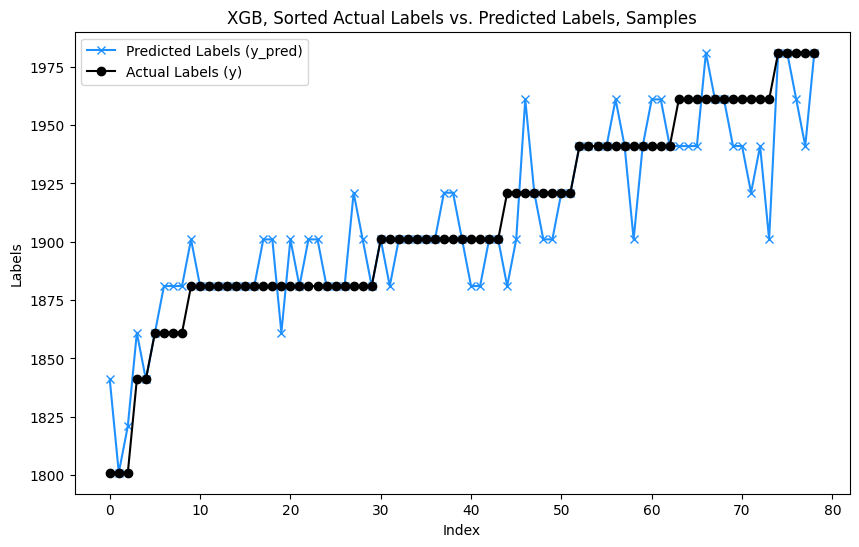

In [286]:
sample_size = int(len(y_test_f) * 0.005)  # Adjust the percentage as needed
indices = np.random.choice(len(y_test_f), sample_size, replace=False)

sorted_indices = np.argsort(y_test_f[indices])

# Rearrange y_pred according to the sorted y
y_test_f_sorted = y_test_f[indices][sorted_indices]
y_test_f_XGB_sorted = y_test_f_XGB[indices][sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Plot corresponding y_pred
plt.plot(y_test_f_XGB_sorted, label='Predicted Labels (y_pred)', marker='x', linestyle='-', color='dodgerblue')

# Plot sorted y
plt.plot(y_test_f_sorted, label='Actual Labels (y)', marker='o', linestyle='-', color='black')

plt.xlabel('Index')
plt.ylabel('Labels')
plt.title('XGB, Sorted Actual Labels vs. Predicted Labels, Samples')
plt.legend()

plt.show()

In [236]:
correlation_matrix = np.corrcoef(y_test_f_XGB, y_test_f)

# The correlation coefficient is the off-diagonal value in the matrix
pearson_correlation = correlation_matrix[0, 1]

print(f"Pearson correlation: {pearson_correlation}")

Pearson correlation: 0.8005180961768179


In [243]:
print(accuracy_conferral(y_test_f_XGB,y_test_f))

0.8361772610788174


# NN softmax

Overfitting mini dataset

In [135]:
y_mini_c = date_to_class(y_mini)
y_train_c = date_to_class(y_train)
y_test_c = date_to_class(y_test)

In [136]:
model2 = MLPClassifier(hidden_layer_sizes=(32,16), activation='relu', solver='adam', max_iter=1000, alpha=0.1)

model2.fit(X_mini, y_mini_c)

# 使用测试集进行预测
y_pred = model2.predict(X_mini)

# 计算准确率
accuracy = accuracy_score(y_mini_c, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 62.53%


### Whole dataset

In [52]:
model3 = MLPClassifier(hidden_layer_sizes=(128,64), activation='relu', solver='adam', max_iter=1000, alpha=0.1)

model3.fit(X_train, y_train_c)

y_pred = model3.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test_c, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 46.49%


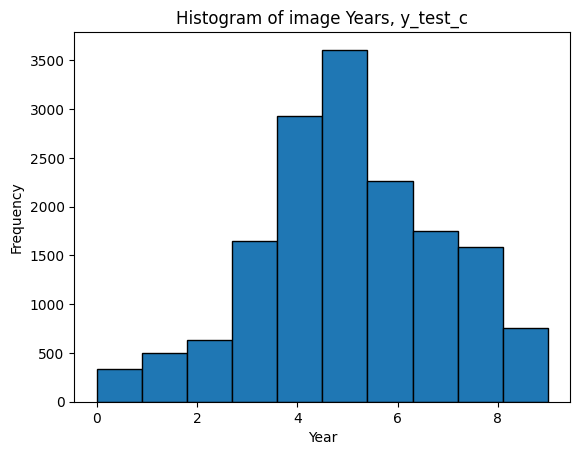

In [53]:
plt.hist(y_test_c, bins=num_c, edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of image Years, y_test_c')

# Display the histogram
plt.show()

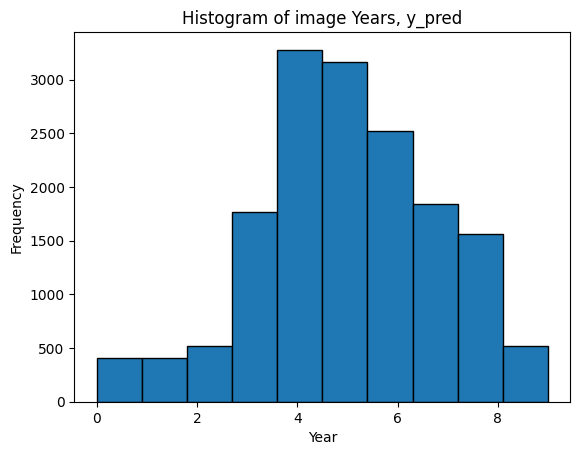

In [54]:
plt.hist(y_pred, bins=num_c, edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of image Years, y_pred')

# Display the histogram
plt.show()

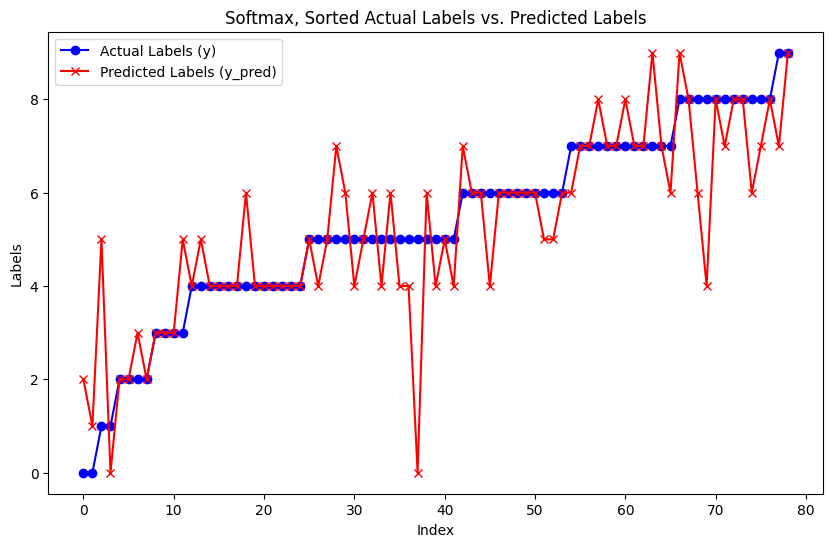

In [55]:
sample_size = int(len(y_test_c) * 0.005)  # Adjust the percentage as needed
indices = np.random.choice(len(y_test_c), sample_size, replace=False)

sorted_indices = np.argsort(y_test_c[indices])

# Rearrange y_pred according to the sorted y
y_test_c_sorted = y_test_c[indices][sorted_indices]
y_pred_sorted = y_pred[indices][sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Plot sorted y
plt.plot(y_test_c_sorted, label='Actual Labels (y)', marker='o', linestyle='-', color='b')

# Plot corresponding y_pred
plt.plot(y_pred_sorted, label='Predicted Labels (y_pred)', marker='x', linestyle='-', color='r')

plt.xlabel('Index')
plt.ylabel('Labels')
plt.title('Softmax, Sorted Actual Labels vs. Predicted Labels')
plt.legend()

plt.show()

In [56]:
correlation_matrix = np.corrcoef(y_test_c_sorted, y_pred_sorted)

# The correlation coefficient is the off-diagonal value in the matrix
pearson_correlation = correlation_matrix[0, 1]

print(f"Pearson correlation: {pearson_correlation}")

Pearson correlation: 0.8162921308935321


In [57]:
y_test_random = np.random.randint(0, num_c, size=y_pred_sorted.shape[0])

correlation_matrix = np.corrcoef(y_test_random, y_pred_sorted)

# The correlation coefficient is the off-diagonal value in the matrix
pearson_correlation = correlation_matrix[0, 1]

print(f"Pearson correlation: {pearson_correlation}")
y_test_random

Pearson correlation: -0.13441650468997138


array([9, 1, 9, 6, 0, 2, 4, 8, 4, 3, 7, 7, 6, 8, 7, 5, 0, 8, 3, 8, 0, 5,
       9, 2, 5, 4, 9, 0, 9, 1, 2, 9, 2, 9, 0, 8, 7, 6, 7, 5, 1, 0, 0, 0,
       2, 3, 1, 6, 0, 1, 2, 5, 0, 9, 0, 5, 6, 4, 4, 0, 0, 9, 9, 7, 1, 0,
       1, 7, 8, 9, 0, 5, 8, 9, 9, 4, 0, 5, 0])

## Fine tuning

In [224]:
# param_grid = {
#     'hidden_layer_sizes': [(4,2),(8,4),(16, 8),(32, 16),(64, 32), (128, 64), (256, 128)],
# }
# param_grid = {
#     'hidden_layer_sizes': [(4,2),(8,4),(16, 8),(32, 16),(16, 4), (16, 2), (16, 16)],
# }
param_grid = {
    'hidden_layer_sizes': [(16, 8),(32, 8),(8, 8),(4,8)],
}

model_MLP = MLPClassifier(activation='relu', solver='adam', max_iter=1000, alpha=0.1)


grid_search = GridSearchCV(estimator=model_MLP, param_grid=param_grid, 
                           cv=3, scoring='roc_auc_ovr', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train_le)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=MLPClassifier(alpha=0.1, max_iter=1000), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(16, 8), (32, 8), (8, 8),
                                                (4, 8)]},
             scoring='roc_auc_ovr', verbose=2)

In [225]:
print("Best parameters found: ", grid_search.best_params_)
# seave model
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'model/MLP_model.pkl')
model_MLP = joblib.load('model/MLP_model.pkl')

# load model
y_test_MLP = model_MLP.predict(X_test).astype(int)

# y_test_f_xg = le.inverse_transform(y_test_xg)
y_test_f_MLP = le.inverse_transform(y_test_MLP)

accuracy = accuracy_score(y_test_f_MLP, y_test_f)
print(f'Accuracy: {accuracy}')


Best parameters found:  {'hidden_layer_sizes': (16, 8)}
Accuracy: 0.47952997062316394


In [226]:
y_pred_prob = model_MLP.predict_proba(X_test)
y_pred_prob = np.exp(y_pred_prob)/np.sum(np.exp(y_pred_prob),axis = 1, keepdims=True)

unique_y_train = np.unique(y_train_f)
unique_y_test = np.unique(y_test_f)
classes_in_test_not_in_train = np.setdiff1d(unique_y_test, unique_y_train)
if classes_in_test_not_in_train.shape[0] != 0:
    print("There is at least 1 class in y_test that does not exist in y_train. We need to redesign codes to consider this issue.")
y_test_le = le.transform(y_test_f)


auc = roc_auc_score(y_test_le, y_pred_prob, multi_class='ovr', average='weighted')
print(f'AUC: {auc}')

AUC: 0.865484882359476


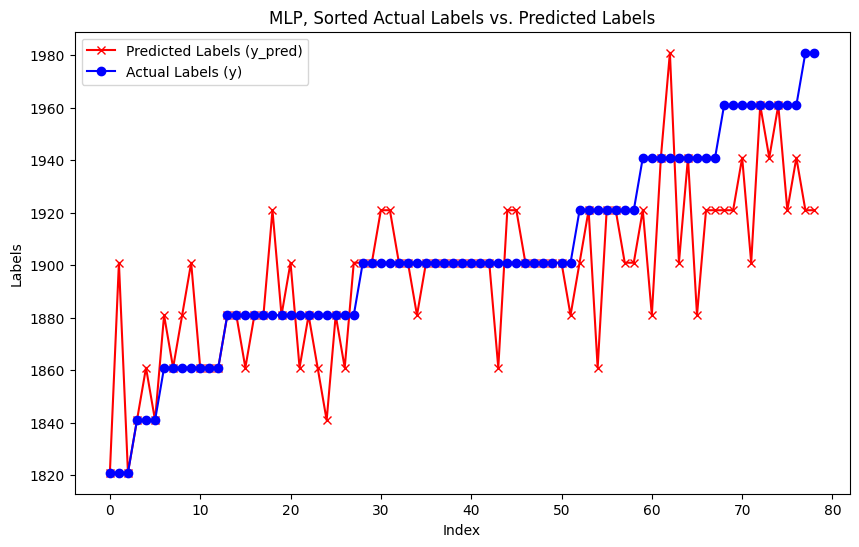

In [228]:
sample_size = int(len(y_test_f) * 0.005)  # Adjust the percentage as needed
indices = np.random.choice(len(y_test_f), sample_size, replace=False)

sorted_indices = np.argsort(y_test_f[indices])

# Rearrange y_pred according to the sorted y
y_test_f_sorted = y_test_f[indices][sorted_indices]
y_test_f_MLP_sorted = y_test_f_MLP[indices][sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Plot corresponding y_pred
plt.plot(y_test_f_MLP_sorted, label='Predicted Labels (y_pred)', marker='x', linestyle='-', color='r')

# Plot sorted y
plt.plot(y_test_f_sorted, label='Actual Labels (y)', marker='o', linestyle='-', color='b')


plt.xlabel('Index')
plt.ylabel('Labels')
plt.title('MLP, Sorted Actual Labels vs. Predicted Labels')
plt.legend()

plt.show()

In [229]:
correlation_matrix = np.corrcoef(y_test_f_MLP, y_test_f)

# The correlation coefficient is the off-diagonal value in the matrix
pearson_correlation = correlation_matrix[0, 1]

print(f"Pearson correlation: {pearson_correlation}")

Pearson correlation: 0.8032565392279593


In [246]:
print(accuracy_conferral(y_test_f_MLP,y_test_f))

0.8403025189074317


# LightGBM

In [18]:
y_mini_f = date_floor(y_mini)
print(y_mini_f)

le = LabelEncoder()
le.fit(y_mini_f)
y_mini_le = le.transform(y_mini_f)

[1901 1901 1921 ... 1901 1921 1821]


In [41]:
# Define the XGBoost model for multi-class classification
model4 = lgb.LGBMClassifier(
    objective='multiclass',  # 多类分类
    num_class=num_c,            # 类别数，这里是10个年份
    boosting_type='gbdt',    # 默认的提升方法
    metric='multi_logloss',   # 多类对数损失
    min_child_samples= 50, #tuned
    num_leaves= 100 # tuned
)

# Train the model
model4.fit(X_mini, y_mini_le)

# Make predictions
y_mini_xg = model4.predict(X_mini)

y_mini_f_xg =le.inverse_transform(y_mini_xg) 

# Evaluate the model
accuracy = accuracy_score(y_mini_f_xg, y_mini_f)
print(f'Accuracy: {accuracy}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 47928, number of used features: 512
[LightGBM] [Info] Start training from score -3.828558
[LightGBM] [Info] Start training from score -3.500207
[LightGBM] [Info] Start training from score -3.216854
[LightGBM] [Info] Start training from score -2.255473
[LightGBM] [Info] Start training from score -1.698249
[LightGBM] [Info] Start training from score -1.505926
[LightGBM] [Info] Start training from score -1.919087
[LightGBM] [Info] Start training from score -2.230509
[LightGBM] [Info] Start training from score -2.299003
[LightGBM] [Info] Start training from score -3.128715
Accuracy: 0.99933233183108


In [24]:
y_train_f = date_floor(y_train)
y_test_f = date_floor(y_test)

le = LabelEncoder()
le.fit(y_train_f)
y_train_le = le.transform(y_train_f)


In [39]:
# Define the XGBoost model for multi-class classification
model5 = lgb.LGBMClassifier(
    objective='multiclass',  # 多类分类
    num_class=num_c,            # 类别数，这里是10个年份
    boosting_type='gbdt',    # 默认的提升方法
    metric='multi_logloss',   # 多类对数损失
    min_child_samples= 50, #tuned
    num_leaves= 100 # tuned
)


# Train the model
model5.fit(X_train, y_train_le)

# Make predictions
# y_test_xg = model.predict(y_test)
y_test_xg = model5.predict(X_test)

# y_test_f_xg = le.inverse_transform(y_test_xg)
y_test_f_xg = le.inverse_transform(y_test_xg)

# Evaluate the model
accuracy = accuracy_score(y_test_f_xg, y_test_f)
print(f'Accuracy: {accuracy}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 47928, number of used features: 512
[LightGBM] [Info] Start training from score -3.828558
[LightGBM] [Info] Start training from score -3.500207
[LightGBM] [Info] Start training from score -3.216854
[LightGBM] [Info] Start training from score -2.255473
[LightGBM] [Info] Start training from score -1.698249
[LightGBM] [Info] Start training from score -1.505926
[LightGBM] [Info] Start training from score -1.919087
[LightGBM] [Info] Start training from score -2.230509
[LightGBM] [Info] Start training from score -2.299003
[LightGBM] [Info] Start training from score -3.128715
Accuracy: 0.4848428026751672


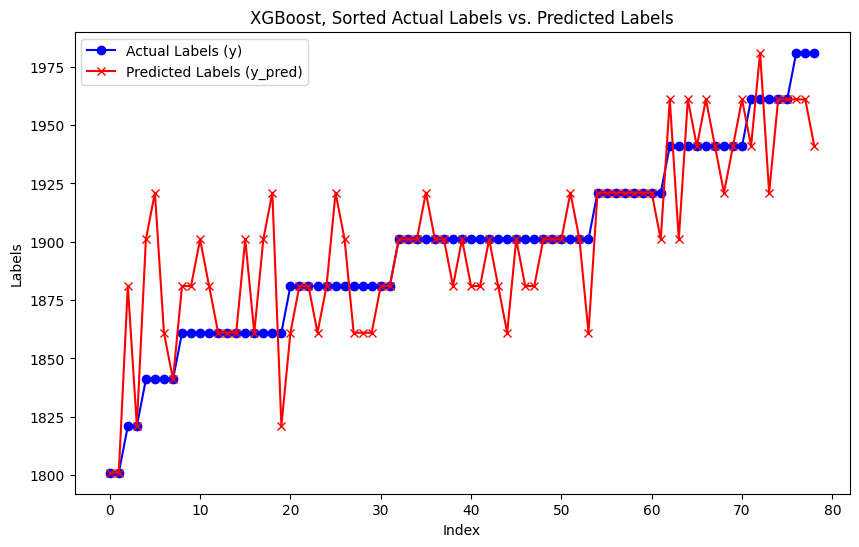

In [26]:
sample_size = int(len(y_test_f) * 0.005)  # Adjust the percentage as needed
indices = np.random.choice(len(y_test_f), sample_size, replace=False)

sorted_indices = np.argsort(y_test_f[indices])

# Rearrange y_pred according to the sorted y
y_test_f_sorted = y_test_f[indices][sorted_indices]
y_test_f_xg_sorted = y_test_f_xg[indices][sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Plot sorted y
plt.plot(y_test_f_sorted, label='Actual Labels (y)', marker='o', linestyle='-', color='b')

# Plot corresponding y_pred
plt.plot(y_test_f_xg_sorted, label='Predicted Labels (y_pred)', marker='x', linestyle='-', color='r')

plt.xlabel('Index')
plt.ylabel('Labels')
plt.title('XGBoost, Sorted Actual Labels vs. Predicted Labels')
plt.legend()

plt.show()

### tune hyperparameters

In [74]:
param_dist0 = {
    'num_leaves': [31, 100, 200],
    'max_depth': [-1, 6, 12],
    'min_child_samples': [10, 20, 50]
}

model6 = lgb.LGBMClassifier(objective='multiclass', num_class=num_c)


# grid_search = GridSearchCV(estimator=model6, param_grid=param_dist0, cv=2, 
#                              scoring='accuracy', verbose = 1)
grid_search = GridSearchCV(estimator=model6, param_grid=param_dist0, cv=2, 
                             scoring='roc_auc_ovr', verbose = 1)
grid_search.fit(X_train, y_train_le)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 23964, number of used features: 512
[LightGBM] [Info] Start training from score -3.828558
[LightGBM] [Info] Start training from score -3.499517
[LightGBM] [Info] Start training from score -3.217375
[LightGBM] [Info] Start training from score -2.255473
[LightGBM] [Info] Start training from score -1.698135
[LightGBM] [Info] Start training from score -1.506020
[LightGBM] [Info] Start training from score -1.918944
[LightGBM] [Info] Start training from score -2.230703
[LightGBM] [Info] Start training from score -2.299003
[LightGBM] [Info] Start training from score -3.128715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010711 seconds.
You

/home/cx2219/miniconda3/envs/mlprj/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 47928, number of used features: 512
[LightGBM] [Info] Start training from score -3.828558
[LightGBM] [Info] Start training from score -3.500207
[LightGBM] [Info] Start training from score -3.216854
[LightGBM] [Info] Start training from score -2.255473
[LightGBM] [Info] Start training from score -1.698249
[LightGBM] [Info] Start training from score -1.505926
[LightGBM] [Info] Start training from score -1.919087
[LightGBM] [Info] Start training from score -2.230509
[LightGBM] [Info] Start training from score -2.299003
[LightGBM] [Info] Start training from score -3.128715


GridSearchCV(cv=2,
             estimator=LGBMClassifier(num_class=10, objective='multiclass'),
             param_grid={'max_depth': [-1, 6, 12],
                         'min_child_samples': [10, 20, 50],
                         'num_leaves': [31, 100, 200]},
             scoring='roc_auc_ovr', verbose=1)

In [91]:
print("Best parameters found: ", grid_search.best_params_)
# seave model
best_model = grid_search.best_estimator_
best_model.booster_.save_model('model/LGBM.json')
model_LGBM = lgb.Booster(model_file='model/LGBM.json')

# load model
y_test_LGBM = np.argmax(model_LGBM.predict(X_test), axis=1)

# y_test_f_xg = le.inverse_transform(y_test_xg)
y_test_f_LGBM = le.inverse_transform(y_test_LGBM)

accuracy = accuracy_score(y_test_f_LGBM, y_test_f)
print(f'Accuracy: {accuracy}')


Best parameters found:  {'max_depth': -1, 'min_child_samples': 50, 'num_leaves': 100}
Accuracy: 0.4848428026751672


In [92]:
y_pred_prob = model_LGBM.predict_proba(X_test)

unique_y_train = np.unique(y_train_f)
unique_y_test = np.unique(y_test_f)
classes_in_test_not_in_train = np.setdiff1d(unique_y_test, unique_y_train)
if classes_in_test_not_in_train.shape[0] != 0:
    print("There is at least 1 class in y_test that does not exist in y_train. We need to redesign codes to consider this issue.")
y_test_le = le.transform(y_test_f)


auc = roc_auc_score(y_test_le, y_pred_prob, multi_class='ovr', average='weighted')
print(f'AUC: {auc}')

AUC: 0.8642000767677577


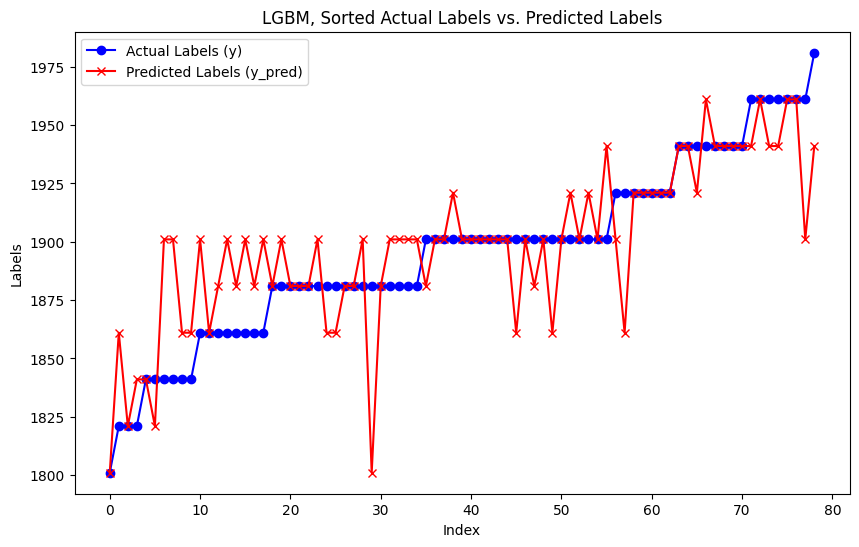

In [86]:
sample_size = int(len(y_test_f) * 0.005)  # Adjust the percentage as needed
indices = np.random.choice(len(y_test_f), sample_size, replace=False)

sorted_indices = np.argsort(y_test_f[indices])

# Rearrange y_pred according to the sorted y
y_test_f_sorted = y_test_f[indices][sorted_indices]
y_test_f_LGBM_sorted = y_test_f_LGBM[indices][sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Plot sorted y
plt.plot(y_test_f_sorted, label='Actual Labels (y)', marker='o', linestyle='-', color='b')

# Plot corresponding y_pred
plt.plot(y_test_f_LGBM_sorted, label='Predicted Labels (y_pred)', marker='x', linestyle='-', color='r')

plt.xlabel('Index')
plt.ylabel('Labels')
plt.title('LGBM, Sorted Actual Labels vs. Predicted Labels')
plt.legend()

plt.show()

In [83]:
correlation_matrix = np.corrcoef(y_test_f_LGBM, y_test_f)

# The correlation coefficient is the off-diagonal value in the matrix
pearson_correlation = correlation_matrix[0, 1]

print(f"Pearson correlation: {pearson_correlation}")

Pearson correlation: 0.7987039681495365


In [244]:
print(accuracy_conferral(y_test_f_LGBM,y_test_f))

0.8378023626476655


# Chatgpt analysis

In [269]:
file_path = 'open_ai_few_shot.xlsx'
df = pd.read_excel(file_path)
gpt_min = 1800
gpt_max = 2000


# Assuming the Excel file contains two arrays in two columns (replace 'Column1' and 'Column2' with actual column names)
y_test_gpt = np.array(df['y_test'].to_numpy(),dtype=int)  # Convert the first column to a NumPy array

y_pred_gpt_text = df['y_pred'].to_numpy()
y_pred_gpt = np.zeros_like(y_pred_gpt_text, dtype=int)

dontknow = 0
for i in range(y_pred_gpt_text.shape[0]):
    if bool(re.match(r'^\d{4}$', y_pred_gpt_text[i])):
        y_pred_gpt[i] = int(y_pred_gpt_text[i])
    else:
        dontknow += 1
        if y_test_gpt[i]<gpt_max-100:
            y_pred_gpt[i] = y_test_gpt[i]+100
        else:
            y_pred_gpt[i] = y_test_gpt[i]-100
print(dontknow)
y_pred_gpt = np.clip(y_pred_gpt, 1750, 2050)
# y_pred_gpt = np.clip(y_pred_gpt, gpt_min, gpt_max)

# Display the arrays
print("y_test_gpt:", y_test_gpt)
print("y_pred_got:", y_pred_gpt)
print(y_pred_gpt.shape)

88
y_test_gpt: [1969 1857 1901 ... 1921 1837 1978]
y_pred_got: [1946 1865 1896 ... 1946 1855 1967]
(16042,)


In [343]:
y_test_gpt_f = date_nearby(y_test_gpt)
y_pred_gpt_f = date_nearby(y_pred_gpt)
print(y_test_gpt_f.dtype, y_pred_gpt_f.dtype)
accuracy = accuracy_score(y_test_gpt_f, y_pred_gpt_f)
print(f'Accuracy: {accuracy}')


int64 int64
Accuracy: 0.4650916344595437


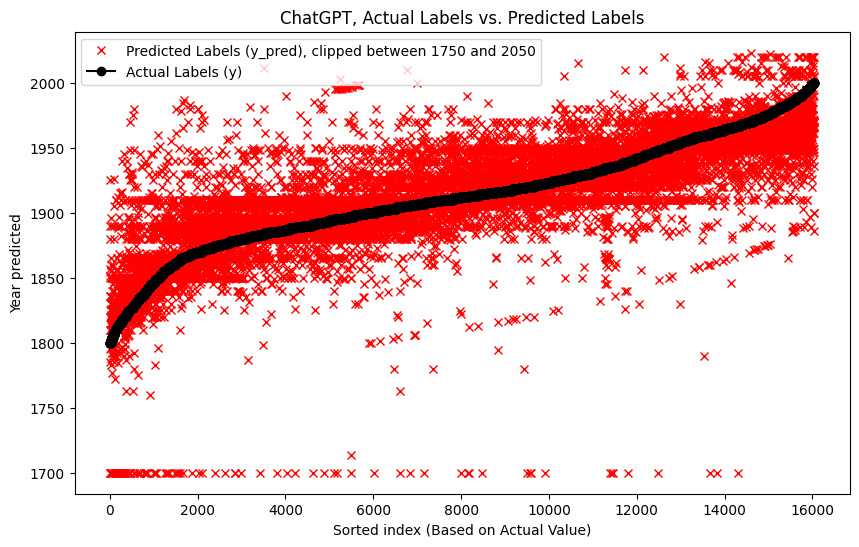

In [344]:
# regression

sample_size = int(len(y_test_gpt) * 1)  # Adjust the percentage as needed
indices = np.random.choice(len(y_test_gpt), sample_size, replace=False)



sorted_indices = np.argsort(y_test_gpt[indices])

# Rearrange y_pred according to the sorted y
y_test_f_sorted = y_test_gpt[indices][sorted_indices]
y_test_f_gpt_sorted = y_pred_gpt[indices][sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Plot corresponding y_pred
plt.plot(y_test_f_gpt_sorted, label='Predicted Labels (y_pred), clipped between 1750 and 2050', marker='x', linestyle='none', color='r')

# Plot sorted y
plt.plot(y_test_f_sorted, label='Actual Labels (y)', marker='o', linestyle='-', color='black')

plt.xlabel('Sorted index (Based on Actual Value)')
plt.ylabel('Year predicted')
plt.title('ChatGPT, Actual Labels vs. Predicted Labels')
plt.legend()

plt.show()

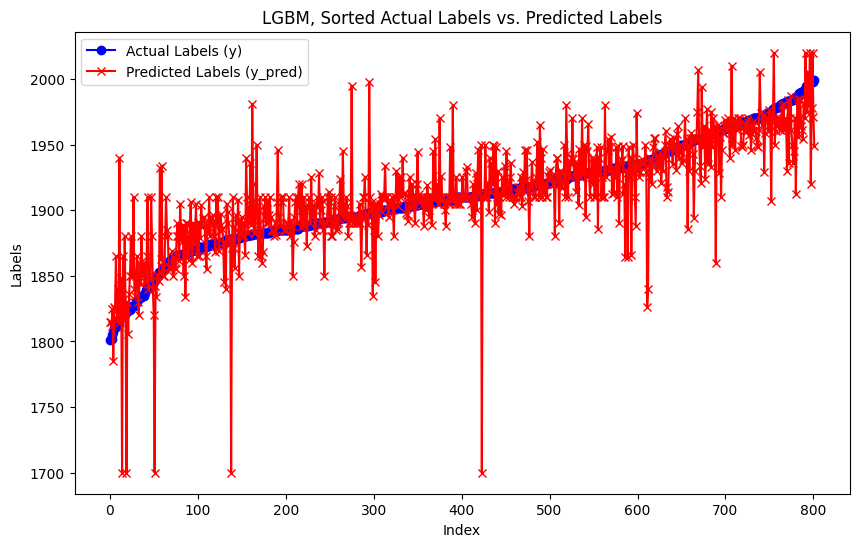

In [345]:
# regression

sample_size = int(len(y_test_gpt) * 0.05)  # Adjust the percentage as needed
indices = np.random.choice(len(y_test_gpt), sample_size, replace=False)



sorted_indices = np.argsort(y_test_gpt[indices])

# Rearrange y_pred according to the sorted y
y_test_f_sorted = y_test_gpt[indices][sorted_indices]
y_test_f_gpt_sorted = y_pred_gpt[indices][sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Plot sorted y
plt.plot(y_test_f_sorted, label='Actual Labels (y)', marker='o', linestyle='-', color='b')

# Plot corresponding y_pred
plt.plot(y_test_f_gpt_sorted, label='Predicted Labels (y_pred)', marker='x', linestyle='-', color='r')

plt.xlabel('Index')
plt.ylabel('Labels')
plt.title('LGBM, Sorted Actual Labels vs. Predicted Labels')
plt.legend()

plt.show()

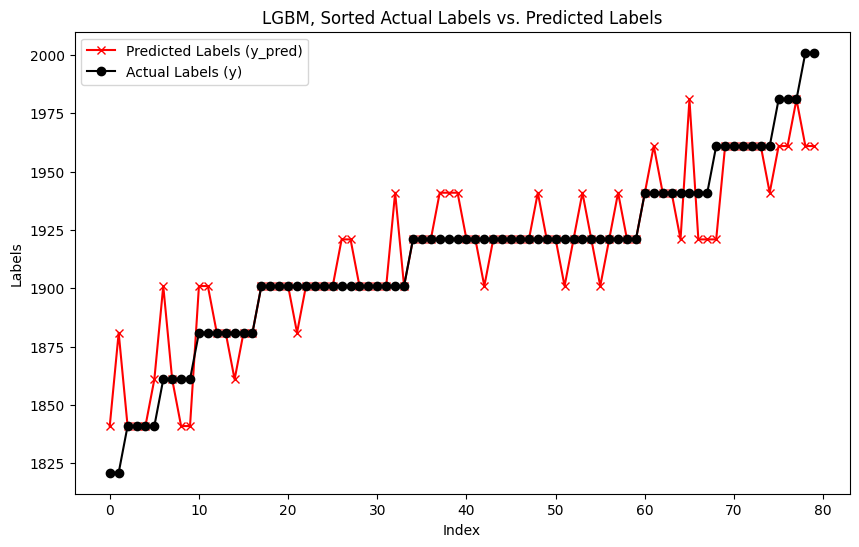

In [346]:
# regression

sample_size = int(len(y_test_gpt_f) * 0.005)  # Adjust the percentage as needed
indices = np.random.choice(len(y_test_gpt_f), sample_size, replace=False)



sorted_indices = np.argsort(y_test_gpt_f[indices])

# Rearrange y_pred according to the sorted y
y_test_f_sorted = y_test_gpt_f[indices][sorted_indices]
y_test_f_gpt_sorted = y_pred_gpt_f[indices][sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Plot corresponding y_pred
plt.plot(y_test_f_gpt_sorted, label='Predicted Labels (y_pred)', marker='x', linestyle='-', color='r')

# Plot sorted y
plt.plot(y_test_f_sorted, label='Actual Labels (y)', marker='o', linestyle='-', color='black')


plt.xlabel('Index')
plt.ylabel('Labels')
plt.title('LGBM, Sorted Actual Labels vs. Predicted Labels')
plt.legend()

plt.show()

In [347]:
correlation_matrix = np.corrcoef(y_test_gpt_f, y_pred_gpt_f)

# The correlation coefficient is the off-diagonal value in the matrix
pearson_correlation = correlation_matrix[0, 1]

print(f"Pearson correlation: {pearson_correlation}")

Pearson correlation: 0.7883921830169814


In [348]:
correlation_matrix = np.corrcoef(y_test_gpt, y_pred_gpt)

# The correlation coefficient is the off-diagonal value in the matrix
pearson_correlation = correlation_matrix[0, 1]

print(f"Pearson correlation: {pearson_correlation}")

Pearson correlation: 0.8014112942328598


In [349]:
print(accuracy_conferral(y_test_gpt,y_pred_gpt, 20))

0.7458546315920708


In [350]:
print(accuracy_conferral(y_test_gpt_f,y_pred_gpt_f, 20))

0.85344720109712


In [351]:
dif = y_test_gpt_f - y_pred_gpt_f
RMSE = np.sqrt(np.sum(dif**2/dif.shape[0]))
print(RMSE)


27.16134084694485
